<a href="https://colab.research.google.com/github/Manuelstv/mercado-financeiro/blob/main/pesquisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import seaborn as sns
import math
import random
import plotly.graph_objects as go
from datetime import datetime

import scipy.signal
from scipy import stats
from scipy.stats import norm,t, kurtosis, moment, skew
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs

plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams.update({'font.size': 22})

import warnings
warnings.filterwarnings('ignore')

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
yf.pdr_override()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.55)


#importar dados

In [ ]:
start = "2000-05-16"
end = "2020-09-23"
ativo = yf.download("^BVSP", start = start, end = end)
ativo.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


#definição das variaveis do problema

In [ ]:
ativo["janela"] = np.log(ativo.High - ativo.Low)
ativo["preco_medio"] = (ativo.High + ativo.Low)*0.5

#Normalização da variavel janela


In [ ]:
#media do log-price return
media_janela = ativo["janela"].mean()
#media dos quadrados do log-price return
media_quadrados_janela = (ativo["janela"]**2).mean()
#retorno normalizado
ativo["janela_normalizado"] = (ativo["janela"] - media_janela) / (np.sqrt(media_quadrados_janela - media_janela**2))

#Normalização dos retornos do preço médio

In [ ]:
ativo["retorno_preco_medio"] = np.log(ativo["preco_medio"].shift(-1)) - np.log(ativo["preco_medio"])
#media do log-price return
media = ativo["retorno_preco_medio"].mean()
#media dos quadrados do log-price return
media_quadrados = (ativo["retorno_preco_medio"]**2).mean()
#retorno normalizado
ativo["retorno_preco_medio_normalizado"] = (ativo["retorno_preco_medio"] - media) / (np.sqrt(media_quadrados - media**2))
ativo.head()

,Open,High,Low,Close,Adj Close,Volume,janela,preco_medio,janela_normalizado,retorno_preco_medio,retorno_preco_medio_normalizado
Date,,,,,,,,,,,
2000-05-16,15074.0,15445.0,15074.0,15360.0,15360.0,0,5.916202,15259.5,-1.139384,-0.009945,-0.711558
2000-05-17,15361.0,15361.0,14856.0,14871.0,14871.0,0,6.224558,15108.5,-0.700928,-0.020867,-1.465195
2000-05-18,14876.0,14973.0,14620.0,14627.0,14627.0,0,5.866468,14796.5,-1.210101,-0.036266,-2.527777
2000-05-19,14594.0,14619.0,13920.0,14327.0,14327.0,0,6.549651,14269.5,-0.238675,-0.020783,-1.459398
2000-05-22,14330.0,14369.0,13583.0,13891.0,13891.0,0,6.666957,13976.0,-0.071876,-0.008046,-0.580542


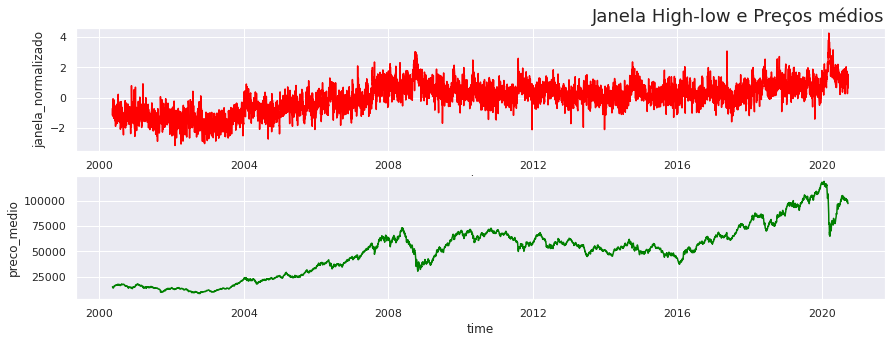

In [ ]:
ativo["time"] = ativo.index
sns.set()

plt.figure(figsize=(14.5,5))
ax = plt.subplot(2,1,1)
ax.set_title("Janela High-low e Preços médios", loc="right", fontsize=18)
sns.lineplot(x ="time", y = "janela_normalizado", data = ativo,color="red")
plt.subplot(2,1,2)
sns.lineplot(x ="time", y = "preco_medio", data = ativo,color="green")

ax=ax

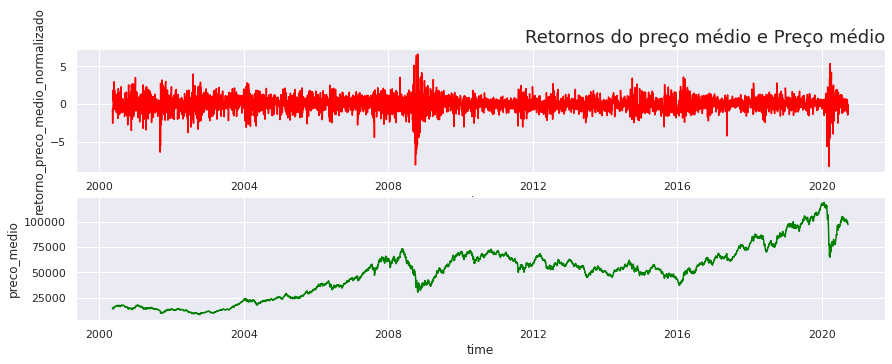

In [ ]:
plt.figure(figsize=(14.5,5))

ax = plt.subplot(2,1,1)
ativo["time"] = ativo.index
ax.set_title("Retornos do preço médio e Preço médio", loc="right", fontsize=18)
sns.lineplot(x ="time", y = "retorno_preco_medio_normalizado", data = ativo,color="red")
plt.subplot(2,1,2)
sns.lineplot(x ="time", y = "preco_medio", data = ativo,color="green")
ax=ax

#Comparação dados historicos da janela high-low com as curvas normais e t de student

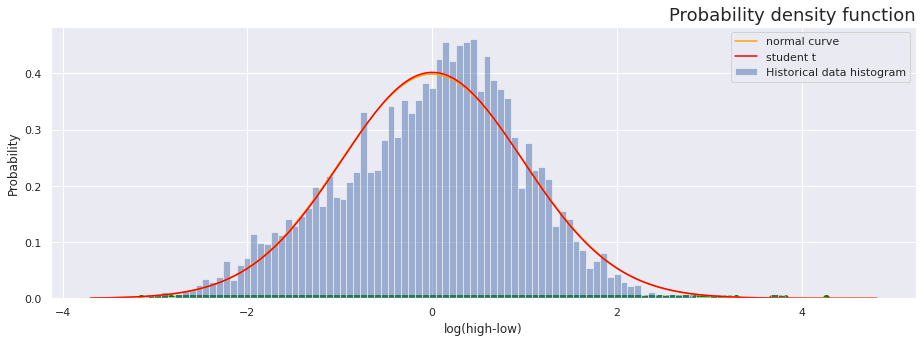

In [ ]:
sns.set()

fig, ax = plt.subplots(figsize=(15.5,5))

ax.hist(ativo['janela_normalizado'], bins=100, label='Historical data histogram', density=True, alpha=0.5)
ax3 = sns.distplot(ativo['janela_normalizado'], fit=norm, kde=False, hist = False, fit_kws={"color":"orange"}, label = "normal curve")
ax2 = sns.distplot(ativo['janela_normalizado'], fit=t, kde=False, hist = False, fit_kws={"color":"red"}, label = "student t")

#ax.plot(kde.support, kde.density, lw=3, label='KDE')
ax.set_xlabel("log(high-low)")
ax.set_ylabel("Probability")
ax.set_title("Probability density function", loc="right", fontsize=18)
ax.scatter(ativo['janela_normalizado'], np.zeros_like(ativo['janela_normalizado']), marker='o', color='green')
#ax.set_ylim([-0.01,0.8])
plt.legend()
ax=ax

In [ ]:
print("A Curtose dos dados é: ",kurtosis(ativo['janela_normalizado'],fisher=0))
print("O skewness é:", skew(ativo['janela_normalizado']))
print("média:",(np.mean(ativo['janela_normalizado'])))
print("mediana:", np.median(ativo['janela_normalizado']))

A Curtose dos dados é:  3.066515287354904
O skewness é: -0.18435332625267764
média: -1.4723630016843672e-14
mediana: 0.10161831845758201


#Comparação dados historicos do retorno médio com as curvas normais e t de student

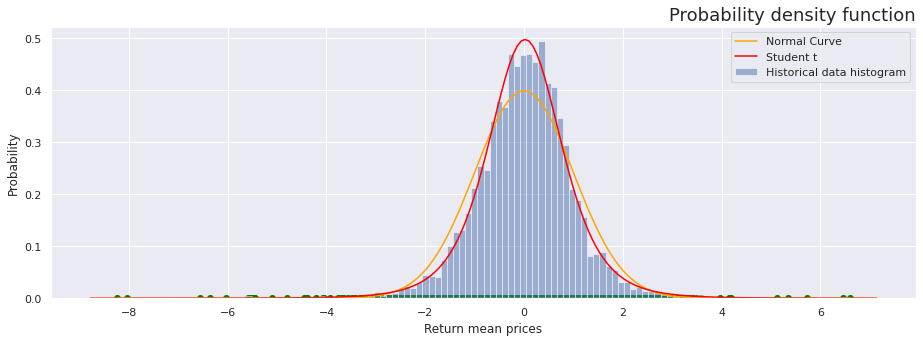

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(15.5,5))

ax.hist(ativo['retorno_preco_medio_normalizado'], bins=120, label='Historical data histogram', density=True, alpha=0.5)
ax3 = sns.distplot(ativo['retorno_preco_medio_normalizado'], fit=norm, kde=False, hist = False, fit_kws={"color":"orange"}, label = "Normal Curve")
ax2 = sns.distplot(ativo['retorno_preco_medio_normalizado'], fit=t, kde=False, hist = False, fit_kws={"color":"red"}, label = "Student t")

#ax.plot(kde.support, kde.density, lw=3, label='KDE')
ax.set_xlabel("Return mean prices")
ax.set_ylabel("Probability")
ax.set_title("Probability density function", loc="right", fontsize=18)
ax.scatter(ativo['retorno_preco_medio_normalizado'], np.zeros_like(ativo['retorno_preco_medio_normalizado']), marker='o', color='green')
#ax.set_ylim([-0.01,0.8])
plt.legend()
ax=ax

#Comparação dos dados do kde x curvas normais e t de student para janela Close-open


In [ ]:
lista_janela_normalizado = list(ativo["janela_normalizado"])
cols = ativo.shape[0]

#variancia (segundo momento central)
sigma = ativo["janela_normalizado"].var()
#largura de banda (janela size)
h1 = 1.06
h2 = 0.2
h = h1*(sigma**2)*(cols**(-h2))

kde = sm.nonparametric.KDEUnivariate(lista_janela_normalizado)
#Não consigo calcular o .cdf e o .evaluate quando o kernel é epanechnickov
#kde.fit(kernel ="epa",fft= False, bw = h )
kde.fit(bw =h)

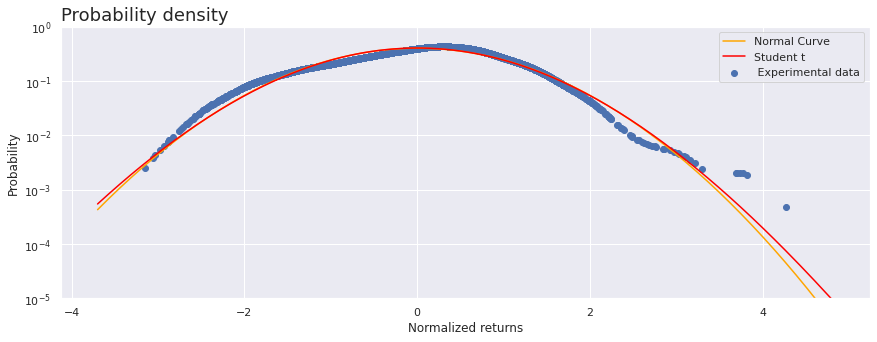

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))

ax.scatter(lista_janela_normalizado, kde.evaluate(lista_janela_normalizado), label =" Experimental data")
ax3 = sns.distplot(lista_janela_normalizado, fit=norm, kde=False, hist = False, fit_kws={"color":"orange"}, label = "Normal Curve")
ax3 = sns.distplot(lista_janela_normalizado, fit=t, kde=False, hist = False, fit_kws={"color":"red"}, label = "Student t")

ax.set_yscale('log')
ax.set_ylim([10**-5,1])
ax.set_xlabel("Normalized returns")
ax.set_ylabel("Probability")
ax.set_title("Probability density", loc="left", fontsize=18)
ax.legend()
ax=ax

#Comparação dos dados do kde x curvas normais e t de student para o preço médio

In [ ]:
ativo = ativo.dropna()
lista_retorno_preco_medio_normalizado = list(ativo["retorno_preco_medio_normalizado"])
cols = ativo.shape[0]

#variancia (segundo momento central)
sigma = ativo["retorno_preco_medio_normalizado"].var()
#largura de banda (janela size)
h1 = 1.06
h2 = 0.2
h = h1*(sigma**2)*(cols**(-h2))

kde = sm.nonparametric.KDEUnivariate(lista_retorno_preco_medio_normalizado)
#Não consigo calcular o .cdf e o .evaluate quando o kernel é epanechnickov
#kde.fit(kernel ="epa",fft= False, bw = h )
kde.fit(bw =h)

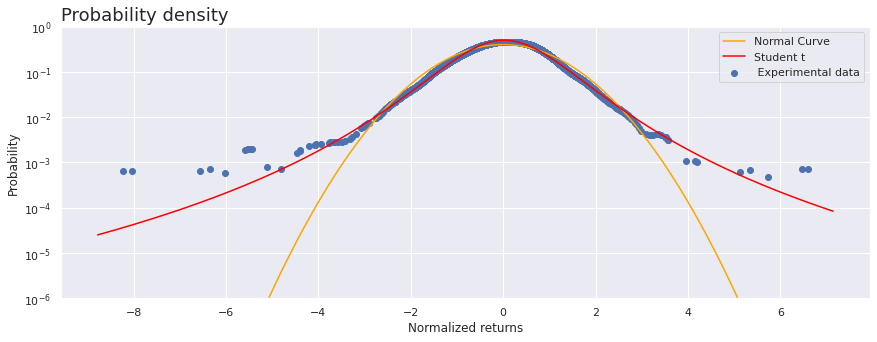

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))

ax.scatter(lista_retorno_preco_medio_normalizado, kde.evaluate(lista_retorno_preco_medio_normalizado), label =" Experimental data")
ax3 = sns.distplot(lista_retorno_preco_medio_normalizado, fit=norm, kde=False, hist = False, fit_kws={"color":"orange"}, label = "Normal Curve")
ax3 = sns.distplot(lista_retorno_preco_medio_normalizado, fit=t, kde=False, hist = False, fit_kws={"color":"red"}, label = "Student t")

ax.set_yscale('log')
ax.set_ylim([10**-6,1])
ax.set_xlabel("Normalized returns")
ax.set_ylabel("Probability")
ax.set_title("Probability density", loc="left", fontsize=18)
ax.legend()
ax=ax

#Variancia

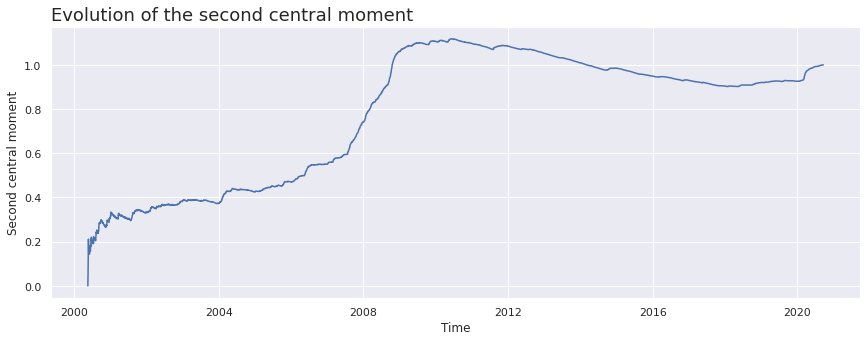

In [ ]:
ativo["variancia"]=0

for i in range(0,cols):
  #array_variancia.append(np.var(ativo.iloc[0:i]["janela janela normalizado"]))
  ativo["variancia"].iloc[i] = np.var(ativo.iloc[0:i]["janela_normalizado"])

fig, ax = plt.subplots(figsize=(14.5,5))
ax.plot(ativo["variancia"])
ax.set_xlabel("Time")
ax.set_ylabel("Second central moment")
ax.set_title("Evolution of the second central moment", loc="left", fontsize=18)
ax = ax

#Variancia da média

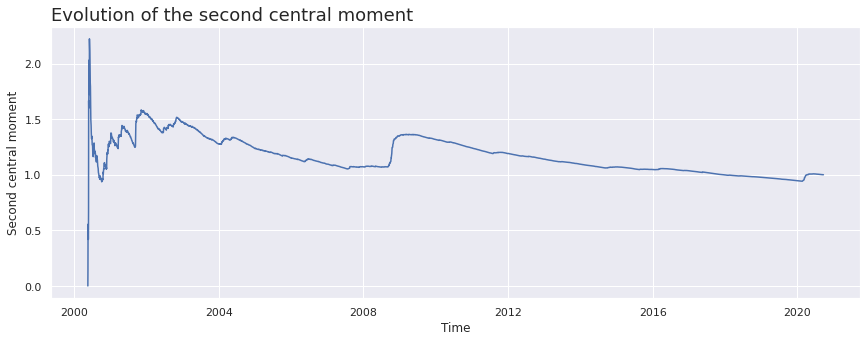

In [ ]:
ativo["variancia"]=0

for i in range(0,cols):
  #array_variancia.append(np.var(ativo.iloc[0:i]["janela janela normalizado"]))
  ativo["variancia"].iloc[i] = np.var(ativo.iloc[0:i]["retorno_preco_medio_normalizado"])

fig, ax = plt.subplots(figsize=(14.5,5))
ax.plot(ativo["variancia"])
ax.set_xlabel("Time")
ax.set_ylabel("Second central moment")
ax.set_title("Evolution of the second central moment", loc="left", fontsize=18)
ax = ax

# Autocorrelação da janela

In [ ]:
from scipy.fft import fft, ifft

N=len(lista_janela_normalizado)
omega = 0.2
dt = 2*np.pi/omega/128
time = np.arange(N)*dt

densidade_espectral = scipy.fft(lista_janela_normalizado)*np.conj(scipy.fft(lista_janela_normalizado))/N
autocorr = scipy.ifft(densidade_espectral).real

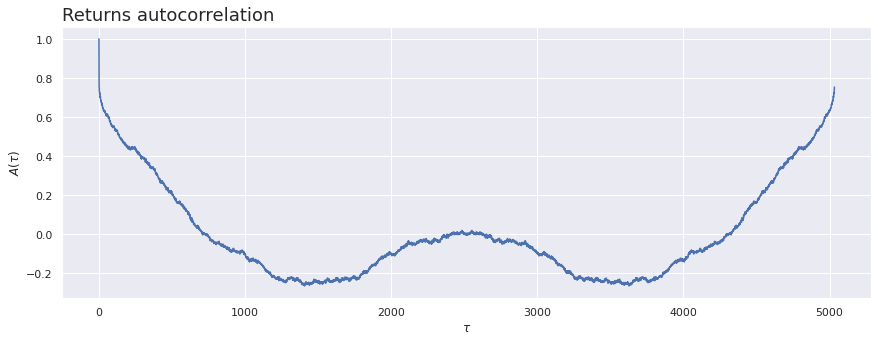

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))
ax.plot(autocorr)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$A(\tau)$')
ax.set_title("Returns autocorrelation", loc="left", fontsize=18)
#ax.set_xlim(-10,)
#ax.set_xscale('log')
ax = ax

In [ ]:
ativo["janela_quadrado"] = ativo["janela"]**2
#media do log-price return
media_log = ativo["janela_quadrado"].mean()
#media dos quadrados do log-price return
media_quadrados_log = (ativo["janela_quadrado"]**2).mean()
#janela janela normalizado
ativo["janela_quadrado_normalizado"] = (ativo["janela_quadrado"] - media_log) / (np.sqrt(media_quadrados_log - media_log**2))
#ativo.head()

In [ ]:
lista_janela_quadrado_normalizado = list(ativo["janela_quadrado_normalizado"])
N=len(lista_janela_quadrado_normalizado)

omega = 0.2
dt = 2*np.pi/omega/128
time = np.arange(N)*dt

densidade_espectral = scipy.fft(lista_janela_quadrado_normalizado)*np.conj(scipy.fft(lista_janela_quadrado_normalizado))/N
autocorr = scipy.ifft(densidade_espectral).real

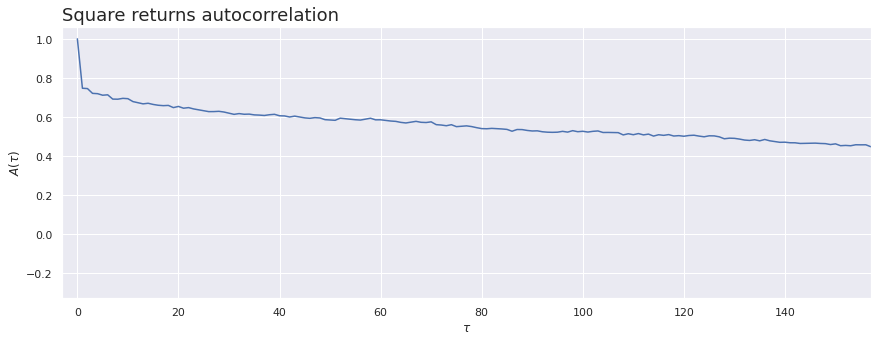

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))
ax.plot(autocorr)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$A(\tau)$')
ax.set_title("Square returns autocorrelation", loc="left", fontsize=18)
ax.set_xlim(-3, 5*2*np.pi/omega)
#ax.set_xscale('log')
ax = ax